# Winery classification using the one-dimensional Gaussian

The **Wine** data set is the running example for our discussion of the *generative approach to classification*. 

The data can be downloaded from the UCI repository (https://archive.ics.uci.edu/ml/datasets/wine). It contains 178 labeled data points, each corresponding to a bottle of wine:
* The features (`x`): a 13-dimensional vector consisting of visual and chemical features for the bottle of wine
* The label (`y`): the winery from which the bottle came (1,2,3)

Before continuing, download the data set and place it in the same directory as this notebook.

## 1. Load in the data set

We start by loading the packages we will need.

In [1]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal
# installing packages for interactive graphs
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

Next, we load the Wine data set. There are 178 data points, each with 13 features and a label (1,2,3).
We will divide these into a training set of 130 points and a test set of 48 points.

In [2]:
# 'wine.data.txt' needs to be in the same directory
data = np.loadtxt('wine.data.txt', delimiter=',')
# Names of features
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']

Fix a particular "random" permutation of the data, and use these to effect the training / test split.
We get four arrays:
* `trainx`: 130x13, the training points
* `trainy`: 130x1, labels of the training points
* `testx`: 48x13, the test points
* `testy`: 48x1, labels of the test points

In [3]:
# Split 178 instances into training set (trainx, trainy) of size 130 and test set (testx, testy) of size 48
# Also split apart data and labels
np.random.seed(0)
perm = np.random.permutation(178)
trainx = data[perm[0:130],1:14]
trainy = data[perm[0:130],0]
testx = data[perm[130:178], 1:14]
testy = data[perm[130:178],0]

Let's see how many training points there are from each class.

In [4]:
sum(trainy==1), sum(trainy==2), sum(trainy==3)

(43, 54, 33)

### <font color="magenta">Fast exercise</font>

Can you figure out how many test points there are from each class? *Note down these three numbers: you will enter it as part of this week's programming assignment.*

In [5]:
# modify this cell
sum(testy == 1), sum(testy == 2), sum(testy == 3)

(16, 17, 15)

## 2. Look at the distribution of a single feature from one of the wineries

Let's pick just one feature: 'Alcohol'. This is the first feature, that is, number 0. Here is a *histogram* of this feature's values under class 1, along with the *Gaussian fit* to this distribution.

<img src="histogram.png">


Hmm: how can we generate a figure like this? 

The following function, **density_plot**, does this for any feature and label. The first line adds an interactive component that lets you choose these parameters using sliders. 

<font color="magenta">Try it out!</font> And then, look at the code carefully to understand exactly what it is doing, line by line.

In [6]:
@interact_manual( feature=IntSlider(0,0,12), label=IntSlider(1,1,3))
def density_plot(feature, label):
    plt.hist(trainx[trainy==label,feature], normed=True)
    #
    mu = np.mean(trainx[trainy==label,feature]) # mean
    var = np.var(trainx[trainy==label,feature]) # variance
    std = np.sqrt(var) # standard deviation
    #
    x_axis = np.linspace(mu - 3*std, mu + 3*std, 1000)
    plt.plot(x_axis, norm.pdf(x_axis,mu,std), 'r', lw=2)
    plt.title("Winery "+str(label) )
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.show()

A Jupyter Widget

In [21]:
def practice():
    std = np.var(trainx[trainy == 1], axis=0)
    pos = np.argmin(std)
    print(pos)
    print(featurenames[pos])
practice()

7
Nonflavanoid phenols


### <font color="magenta">Fast exercise</font>

In the function **density_plot**, the code for plotting the Gaussian density focuses on the region within 3 standard deviations of the mean. Do you see where this happens? Why do you think we make this choice?

Here's something for you to figure out: for which feature (0-12) does the distribution of (training set) values for winery 1 have the *smallest* standard deviation? Write down the answer: you will need to enter it as part of this week's programming assignment.

In [7]:
# modify this cell
std = np.zeros(13)
for feature in range(0,13):
    std[feature] = np.std(trainx[trainy==1,feature])
featurenames[np.argmin(std)]


'Nonflavanoid phenols'

## 3. Fit a Gaussian to each class

Let's define a function that will fit a Gaussian generative model to the three classes, restricted to just a single feature.

In [8]:
# Assumes y takes on values 1,2,3
def fit_generative_model(x,y,feature):
    k = 3 # number of classes
    mu = np.zeros(k+1) # list of means
    var = np.zeros(k+1) # list of variances
    pi = np.zeros(k+1) # list of class weights
    for label in range(1,k+1):
        indices = (y==label)
        mu[label] = np.mean(x[indices,feature])
        var[label] = np.var(x[indices,feature])
        pi[label] = float(sum(indices))/float(len(y))
    return mu, var, pi

Call this function on the feature 'alcohol'. What are the class weights?

In [9]:
feature = 0 # 'alcohol'
mu, var, pi = fit_generative_model(trainx, trainy, feature)
print(pi[1:])

[ 0.33076923  0.41538462  0.25384615]


Next, display the Gaussian distribution for each of the three classes

In [10]:
@interact_manual( feature=IntSlider(0,0,12) )
def show_densities(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        m = mu[label]
        s = np.sqrt(var[label])
        x_axis = np.linspace(m - 3*s, m+3*s, 1000)
        plt.plot(x_axis, norm.pdf(x_axis,m,s), colors[label-1], label="class " + str(label))
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.legend()
    plt.show()

A Jupyter Widget

### <font color="magenta">Fast exercise</font>

Use the widget above to look at the three class densities for each of the 13 features. Here are some questions for you:
* For which feature (0-12) do the densities for classes 1 and 3 *overlap* the most?
* For which feature (0-12) is class 3 the most spread out relative to the other two classes?
* For which feature (0-12) do the three classes seem the most *separated* (this is somewhat subjective at present)?

*Write down the answers to these questions: you will enter them as part of this week's assignment.*

## 4. Predict labels for the test set

How well can we predict the class (1,2,3) based just on one feature? The code below lets us find this out.

In [11]:
@interact( feature=IntSlider(0,0,12) )
def test_model(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)

    k = 3 # Labels 1,2,...,k
    n_test = len(testy) # Number of test points
    score = np.zeros((n_test,k+1))
    for i in range(0,n_test):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + \
            norm.logpdf(testx[i,feature], mu[label], np.sqrt(var[label]))
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # Finally, tally up score
    errors = np.sum(predictions != testy)
    print("Test error using feature " + featurenames[feature] + ": " + str(errors) + "/" + str(n_test))

A Jupyter Widget

### <font color="magenta">One last exercise</font>

In this notebook, we are looking at classifiers that use just one out of a possible 13 features. Choosing a subset of features is called **feature selection**. In general, this is something we would need to do based solely on the *training set*--that is, without peeking at the *test set*.

For the wine data, compute the training error and test error associated with each choice of feature.

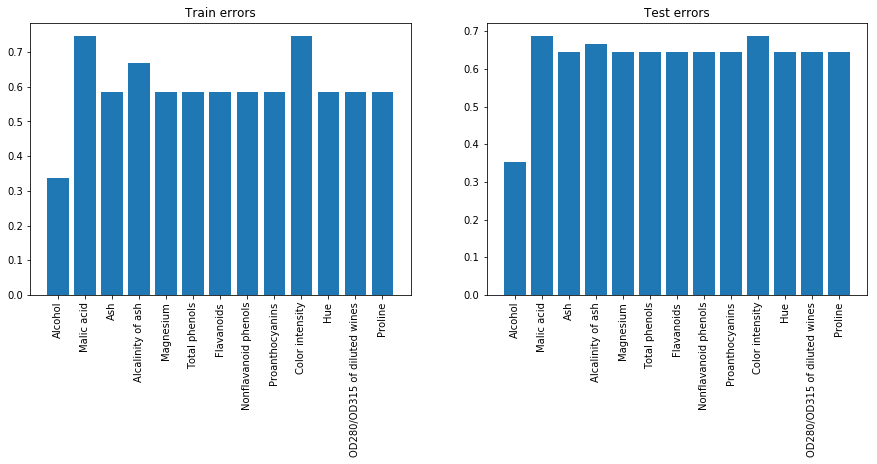

In [25]:
### Write your code here
def plot_train_test_error():
    # Errors when model is trained using a particular feature
    train_errors = np.zeros(13)
    test_errors = np.zeros(13)
    
    for feature_index in range(0, 13):
        mu, var, pi = fit_generative_model(trainx, trainy, feature_index)
        
        k = 3 # Labels 1,2,...,k
        n_test = len(testy) # Number of test points
        n_train = len(trainy) # Number of train points
        test_score = np.zeros((n_test, k+1)) 
        train_score = np.zeros((n_train, k+1)) 
        
        for i in range(0, n_test):
            for label in range(1, k+1):
                test_score[i, label] = np.log(pi[label]) + \
                norm.logpdf(testx[i, feature], mu[label], np.sqrt(var[label]))
        for i in range(0, n_train):
            for label in range(1, k+1):
                train_score[i, label] = np.log(pi[label]) + \
                norm.logpdf(trainx[i, feature], mu[label], np.sqrt(var[label]))

        train_predictions = np.argmax(train_score[:, 1:4], axis=1) + 1
        test_predictions = np.argmax(test_score[:, 1:4], axis=1) + 1
        
        test_error_rate = np.sum(test_predictions != testy) / n_test
        test_errors[feature_index] = test_error_rate
        train_error_rate = np.sum(train_predictions != trainy) / n_train
        train_errors[feature_index] = train_error_rate
        
    # plot results
    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    
    # train errors
    x_pos = np.arange(13)
    ax[0].bar(x_pos, train_errors, align='center')
    ax[0].set_title('Train errors')
    ax[0].set_xticks(x_pos)
    ax[0].set_xticklabels(featurenames)
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(90)
    # test errors
    ax[1].bar(x_pos, test_errors, align='center')
    ax[1].set_title('Test errors')
    ax[1].set_xticks(x_pos)
    ax[1].set_xticklabels(featurenames)
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(90)

    plt.show()
    
    # print results
    
    
plot_train_test_error()

Based on your findings, answer the following questions:
* Which three features have the lowest training error? List them in order (best first).
* Which three features have the lowest test error? List them in order (best first).

*Note down your answers: you will enter them later, as part of this week's programming assignment*.